# GTFS Handler tutorial

In [ ]:
# If using colab
# Takes around 2-3 min
# !pip install git+https://github.com/GeomaticsCaminosUPM/pyGTFSHandler.git
# !pip install -v git+https://github.com/GeomaticsCaminosUPM/UrbanAccessAnalyzer.git
# !pip install matplotlib mapclassify folium
# !apt-get install -y osmium-tool

# Restart notebook after installing this

In [2]:
import sys 
sys.path.append('/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler')
sys.path.append('/home/miguel/Documents/Proyectos/PTLevelofService/accessibility/UrbanAccessAnalyzer')

In [3]:
import sys
import os

from pyGTFSHandler.feed import Feed
from pyGTFSHandler.downloaders.mobility_database import MobilityDatabaseClient
from pyGTFSHandler.downloaders.mobility_database import get_geographic_suggestions_from_string
from pyGTFSHandler.downloaders.mobility_database import get_city_geometry
import pyGTFSHandler.plot_helper as plot_helper
import pyGTFSHandler.processing_helper as processing_helper
from datetime import datetime, date, timedelta, time
import pandas as pd
import geopandas as gpd

import osmnx as ox

import matplotlib.pyplot as plt

import UrbanAccessAnalyzer.isochrones as isochrones
import UrbanAccessAnalyzer.graph_processing as graph_processing
import UrbanAccessAnalyzer.osm as osm
import UrbanAccessAnalyzer.utils as utils

### 1 Paths and data
#### 1.1 City name

Given a city name download its geometry from OpenStreetMap and find its country and region codes

In [4]:
city_name = "Provincia de Alicante, Comunidad Valenciana, España"
city_filename = utils.sanitize_filename(city_name)
aoi = get_city_geometry(city_name)
geo_suggestions = get_geographic_suggestions_from_string(city_name)
geo_suggestions

{'country_codes': ['ES'],
 'subdivision_names': ['Alacant / Alicante', 'Valencian Community'],
 'municipalities': []}

#### 1.2 File paths

Paths where you want to save the downloaded info

In [5]:
base_path = f"{city_filename}" # Base path for all files related with your city or region
gtfs_path = base_path + "/gtfs_files" # GTFS public transport files
results_path = base_path + "/level_of_service" # Accessibility and quality results

In [6]:
os.makedirs(base_path,exist_ok=True)
os.makedirs(gtfs_path,exist_ok=True)
os.makedirs(results_path,exist_ok=True)

### 2 Download GTFS feeds worldwide

This example is for the MobilityData API

This is the organization responsible for the GTFS standard and has info from almost all the world

In [7]:
# Request your refresh token here: https://mobilitydatabase.org/ 
refresh_token = 'AMf-vByYiwMAni1pw6yTpwgwwYFc8HR4y0zUKZGPT4sjJ0wUrIXOfVxF1KotRIvEgAseaaNheL8YczJiCILb6o2PUh-8zjA-qQURzEc8tELlwFiDopMoqJnkDf13AqNaGGnnzTDmYM20AWEquUxcYFAB8Q3e5rI2DcTBSQuiUdHL8bi48xmUJk3tayHpnoicoppi_evDcWYODwOJFcwnta3K7f718w7R2JRM0zDEOYw7nI7thrQa9462BENdpv8zv8mEbBssEa189k6YcV__sQAZlng2EcsCGA'
api = MobilityDatabaseClient(refresh_token)

2025-09-18 10:11:33,036 - INFO - Obtaining/refreshing access token...
2025-09-18 10:11:33,304 - INFO - Access token obtained/refreshed successfully.


#### 2.1 Find Feeds on the API

In [8]:
feeds = api.search_gtfs_feeds(
    country_code=geo_suggestions['country_codes'],
    subdivision_name=geo_suggestions['subdivision_names'], # This info is not always in the feeds metadata. Comment this if you did not find all feeds.
    #municipality=geo_suggestions['municipalities'], # This info is not always in the feeds metadata. Comment this if you did not find all feeds.
    is_official=None, # Set to True if you only want official feeds
    #aoi=aoi, # You could comment the rest of search args and use only aoi but for now the API seems to not do this very well as the metadata is often wrong.
)

for f in feeds:
    print(f['provider'])

2025-09-18 10:11:33,948 - INFO - API Call for combination: {'country_code': 'ES', 'subdivision_name': 'Alacant / Alicante'}
2025-09-18 10:11:34,316 - INFO - API Call for combination: {'country_code': 'ES', 'subdivision_name': 'Valencian Community'}
2025-09-18 10:11:38,322 - INFO - Total unique feeds found: 22


AECFA (Spanish Association for the Coordination and Facilitation of Time Strips)
ALSA buses
Baleària Ferry
BlaBlaCar Bus
Castelló de la Plana Town Hall (city bus)
Collegamenti marittimi Grandi Navi Veloci
Collegamenti marittimi Grimaldi
Empresa Municipal de Transportes de Valencia (EMT Valencia)
FGV - Generalitat Valenciana Metro de Valencia
FGV - Generalitat Valenciana Trains and trams in Alicante and the Costa Blanca
FlixBus
Generalitat Valenciana (Intercity bus)
Gobierno de Cantabria (Buses in Cantabria)
MetroValencia
Renfe
Renfe
Renfe Cercanias
Renfe commuter trains (Cercanias)
Samar Buses
TRAM Alicante
Vectalia Movilidad (Alicante city buses)
Vectalia Movilidad (Urban buses in San Vicente del Raspeig)


#### 2.2A Download current active files

In [9]:
file_paths = api.download_feeds(
    feeds=feeds,
    download_folder=gtfs_path,
    overwrite=False
)

#### 2.2B Download historic files


Download past files and stack them into one unique file

In [10]:
# Not implemented yet

### 3 GTFS process

#### 3.1 Create the gtfs object

This will do:

- Load all .txt files of all gtfs folders given.
- Select only the stops from stops.txt inside the area of interest.
- Crop all trips in stop_times.txt with the stops inside the aoi + 1 more stop.
- Check the stop_sequence in stop_times.txt.
- Deal correctly with trips starting on one day and ending in the following day: hours always in 0-24 range but those trips are marked as next_day True. New service_ids are created to deal with that.
- If the file has frequencies.txt this is processed too dealing with the next day problem.
- If departure or arrival times are empty they get filled.
- A shape direction col is computed as the mean heading of the vector between stop coordinates to mean of the remainning stops coordinates.
- GTFS shapes are for now computed from the stop coordinates.

In [11]:
gtfs = Feed(
        file_paths,
        aoi=aoi,
        stop_group_distance=100, # Group stops into one that are less than x meters (sorry americans) apart. This created or updates the parent_station column
        #start_date=datetime(day=1,month=9,year=2025),
        #end_date=datetime(day=1,month=11,year=2025),
    )

In [12]:
for i,f in enumerate(file_paths):
    if ("emt" in f) or ("municipal" in f):
        print(i," ",f)

7   /home/miguel/Documents/Proyectos/PTLevelofService/accessibility/UrbanAccessAnalyzer/tutorials/provincia_de_alicante__comunidad_valenciana__espana/gtfs_files/mdb795__empresamunicipaldetransportesdevalenciaemtvalencia


In [13]:
gtfs.calendar_new_end_date(datetime(year=2025,month=10,day=30),file_id=7)

#### 3.2 Service intensity

Service intensity is the product of the number of trips per stop times the number of stops in the feed. This is compued for every date in the range.

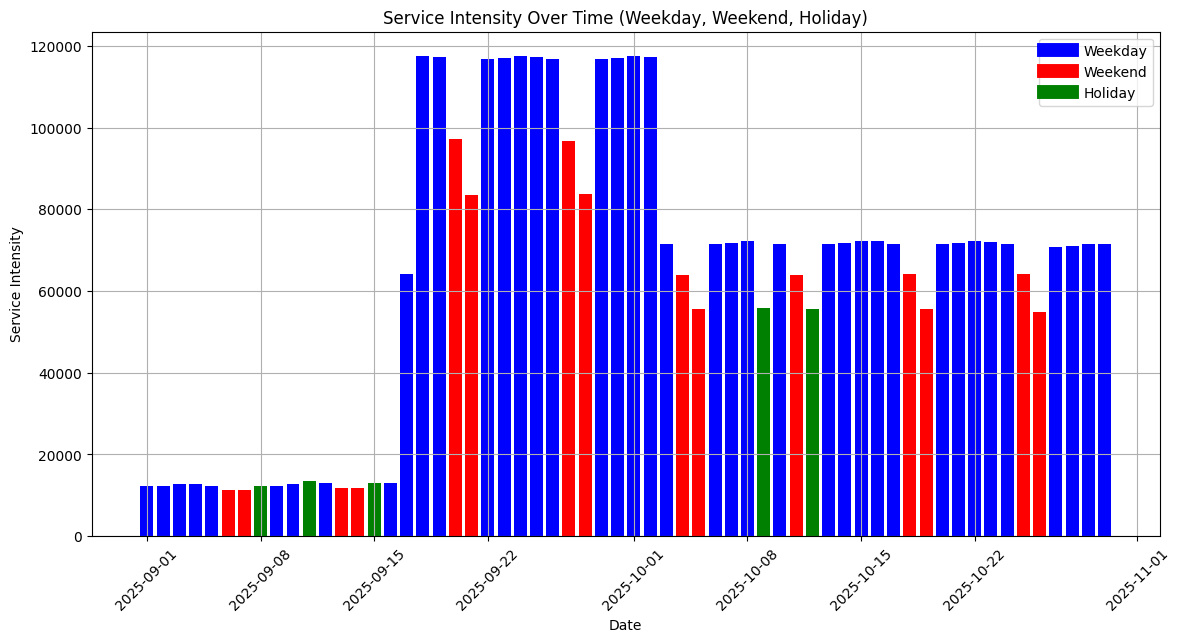

In [14]:
service_intensity = gtfs.get_service_intensity_in_date_range(
    start_date=datetime(year=2025,month=9,day=1), # If None take the feed min date
    end_date=datetime(year=2025,month=10,day=30), # If None take the feed max date
    date_type=None # Could be something like holiday, weekday, or monday to only consider some dates from the range.
)
service_intensity = service_intensity.to_pandas()
plot_helper.plot_service_intensity(service_intensity)

Select the most common weekday for our analysis

In [15]:
weekday_services = service_intensity.loc[
    (service_intensity['holiday'] == False) & (service_intensity['weekend'] == False)
]
idx = processing_helper.most_frequent_row_index(weekday_services['service_intensity'])
selected_weekday = weekday_services.iloc[idx]['date'].to_pydatetime()
selected_weekday 

datetime.datetime(2025, 10, 30, 0, 0)

In [16]:
selected_weekday = datetime(2025,9,19)

#### 3.3 Service quality

Service quality is evaluated depending the route type and the mean frequency in the selected time interval.

By default processing_helper.SERVICE_MATRIX to give grades


prcessing_helper.ROUTE_TYPES_TRANSLATOR translates from gtfs route_types to SERVICE_MATRIX route types and ROUTE_TYPES sets the priority or importance order if a stop has multiple route types

In [17]:
# Lets see what grade is given by default depending on route type and frequency.

processing_helper.SERVICE_MATRIX # interval in minutes. The grading for stops is 1 for best - 12 for worst.

,interval,bus,tram,rail
0,5,2,1,1
1,10,3,2,1
2,15,4,3,2
3,20,5,4,3
4,30,6,5,4
5,45,7,6,5
6,60,8,7,6
7,90,9,8,7
8,120,10,9,8
9,180,11,10,9


In [18]:
start_hour = 8 # start at 8:00
end_hour = 20 # end at 20:900

service_quality_file = processing_helper.get_service_quality(results_path,gtfs,dates=selected_weekday,times=[start_hour,end_hour])
service_quality_gdf = gpd.read_file(service_quality_file)
m = plot_helper.service_quality_map(service_quality_gdf,start_time=start_hour,end_time=end_hour)
m.save(results_path + "/stops_map.html")
# If map does not render
import webbrowser
webbrowser.open(results_path + "/stops_map.html")
m

2025-09-18 10:12:23,691 - INFO - Created 2,972 records


# Accessibility Tutorial

### Set paths

In [19]:
pbf_path = "pbf_files" # For general region or country osm street network files
graph_path = base_path + "/street_network" # City street network graphs

In [20]:
os.makedirs(pbf_path,exist_ok=True)
os.makedirs(graph_path,exist_ok=True)

In [21]:
osm_xml_file = graph_path + f"/{city_filename}.osm" # City osm street network file
full_graph_path = graph_path + f"/{city_filename}_full_graph.graphml" # Full original city street netwrok in graph format
simplified_graph_path = graph_path + f"/{city_filename}_simplified_graph.graphml" # Simplified street network
level_of_service_graph_path = results_path + f"/{city_filename}_level_of_service.graphml" # Street network with quality and accessibility
level_of_service_nodes_path = results_path + f"/{city_filename}_level_of_service_nodes.gpkg" # Street network with quality and accessibility
level_of_service_edges_path = results_path + f"/{city_filename}_level_of_service_edges.gpkg" # Street network with quality and accessibility

## 1 Download street network

### 1.1 Regionwise file and cropping

- Download best regionwise pbf file. (Covers a large area)

- Crop it to cover our aoi and save it in .osm format

In [22]:
# Select what type of street network you want to load
network_filter = osm.osmium_network_filter("walk+bike+primary")
# Download the region pbf file crop it by aoi and convert to osm format
osm.geofabrik_to_osm(osm_xml_file,input_file=pbf_path,aoi=aoi,osmium_filter_args=network_filter,overwrite=False)

File pbf_files does not exist. Downloading best matching geofabrik file.
Fetching Geofabrik index from https://download.geofabrik.de/index-v1.json...
File '/home/miguel/Documents/Proyectos/PTLevelofService/accessibility/UrbanAccessAnalyzer/tutorials/pbf_files/valencia.osm.pbf' already exists. Skipping download.
Applying tag filter: w/highway=track w/highway=secondary_link w/highway=primary w/highway=residential w/highway=tertiary_link w/highway=unclassified w/highway=steps w/highway=cycleway w/highway=trunk_link w/highway=service w/highway=path w/highway=living_street w/highway=tertiary w/highway=primary_link w/highway=trunk w/highway=secondary w/highway=pedestrian w/highway=footway w/foot=yes w/bicycle=yes
Creating .poly file for AOI clipping...
Extracting by geometry...
Finished. Final output: provincia_de_alicante__comunidad_valenciana__espana/street_network/provincia_de_alicante__comunidad_valenciana__espana.osm


'provincia_de_alicante__comunidad_valenciana__espana/street_network/provincia_de_alicante__comunidad_valenciana__espana.osm'

### 1.2 Load to osmnx

This way the street network is a netokx graph

(osmnx could be completely deleted from the process and its functions reimplemented to make it much faster, especially the loading process here)

In [23]:
# Load
G = ox.graph_from_xml(osm_xml_file)
# Project geometry coordinates to UTM system to allow euclidean meassurements in meters (sorry americans)
G = ox.project_graph(G,to_crs=aoi.estimate_utm_crs())
# Save the graph in graphml format to avoid the slow loading process
ox.save_graphml(G,full_graph_path)

### 1.3 Simplify graph

Edges with length smaler than X are deleted and its nodes merged

In [24]:
min_edge_length = 30
G = graph_processing.simplify_graph(G,min_edge_length=min_edge_length,min_edge_separation=min_edge_length*2,undirected=True)
# Save the result in graphml format
ox.save_graphml(G,simplified_graph_path)

## 2 Service points

- Load the points related to the service you want to evaluate (e.g. public transport stops or hospitals...)

- Add those points to the graph as new nodes

In [25]:
points = gpd.read_file(service_quality_file)
points.head(5)

,stop_id,parent_station,stop_name,service_quality_8h_20h,interval_8h_20h,n_services_8h_20h,route_names_8h_20h,route_long_names_8h_20h,shape_directions_8h_20h,route_type_8h_20h,route_type,geometry
0,ALC_file_0,ALC_file_0,Aeropuerto_Alicante-Elche,7.0,44.791667,45.0,['VY:ALC-IBZ_file_0' 'QR:ALC-BCN_file_0' 'IB:A...,['FR:ALC-PMI_file_0' 'UX:ALC-PMI_file_0' 'VY:A...,[47.01338578],bus,bus,POINT (-0.55718 38.28675)
1,0000300000000001_file_1,E0000300000000001_file_1,Alicante,2.0,4.479335,223.0,['8907_file_1' '8502_file_1' '1620431263_file_...,['8452_file_1' '22232_file_1' '22228_file_1' '...,[21.47093227],bus,bus,POINT (-0.49149 38.3375)
2,E0000300000000001_file_1,E0000300000000001_file_1,None,2.0,4.479335,223.0,['8907_file_1' '8502_file_1' '1620431263_file_...,['8452_file_1' '22232_file_1' '22228_file_1' '...,[21.47093227],bus,bus,POINT (-0.49149 38.3375)
3,0000907800000001_file_1,E0000907800000001_file_1,Benidorm_Estacion_De_Autobuses,6.0,24.427778,41.0,['500604_file_11' '22225_file_1' '22223_file_1...,['8401_file_1' '8402_file_1' '22225_file_1' '8...,[253.69776822],bus,bus,POINT (-0.12531 38.55028)
4,E0000907800000001_file_1,E0000907800000001_file_1,None,6.0,24.427778,41.0,['500604_file_11' '22225_file_1' '22223_file_1...,['8401_file_1' '8402_file_1' '22225_file_1' '8...,[253.69776822],bus,bus,POINT (-0.12531 38.55028)


Select the column of the points GeoDataFrame that has the service quality information

In [26]:
service_quality_col = f"service_quality_{start_hour}h_{end_hour}h"

Add the service points to the graph:

- Project the points to the graph edges

- Add new nodes at this projection points

In [27]:
G, osmids = graph_processing.add_points_to_graph(
    points,
    G,
    max_dist=100+min_edge_length, # Maximum distance from point to graph edge to project the point
    min_edge_length=min_edge_length # Minimum edge length after adding the new nodes
)
points['osmid'] = osmids # Add the ids of the nodes in the graph to points

### 3 Compute isochrones

#### 3.1 Distance steps and level of services

We need a DISTANCE_MATRIX to relate level of service classes to service qualities and distance to the service.

and we need a LEVEL_OF_SERIVCES list to order the level of services classes form best to worst (or leave it up to the code is the matrix is very symetric).

In [28]:
distance_matrix = processing_helper.DISTANCE_MATRIX
distance_matrix

,service_quality,300,500,750,1000,1250,1500,2000
0,1,A1,A1,A2,A3,B3,C1,D
1,2,A1,A2,A3,B1,C1,C2,D
2,3,A2,A3,B1,B2,C2,C3,D
3,4,A3,B1,B2,B3,C3,D,E
4,5,B1,B2,B3,C1,D,D,E
5,6,B2,B3,C1,C2,D,D,E
6,7,B3,C1,C2,C3,D,E,F
7,8,C1,C2,C3,D,E,E,F
8,9,C2,C3,D,D,E,E,F
9,10,C3,D,D,D,E,F,F


In [29]:
level_of_services = processing_helper.LEVEL_OF_SERVICES
level_of_services

['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D', 'E', 'F']

Compute the level of service graph:

- First it computes the isochrones with networkx at node level

- Then it add new nodes to make the isochrones exact

- The graph has a new property level_of_service with the level of service class

In [30]:
level_of_service_graph = isochrones.graph(
    G,
    points,
    distance_matrix, # If service_quality_col is None it could be a list of distances
    service_quality_col = service_quality_col, # If all points have the same quality this could be None
    level_of_services=level_of_services, # could be None and it will set to the sorted unique values of the matrix
    min_edge_length=min_edge_length # Do not add new nodes if there will be an edge with less than this length
)
# Save as graphml
ox.save_graphml(G,level_of_service_graph_path)

100%|██████████| 50/50 [06:13<00:00,  7.47s/it]


In [31]:
# Save edges and nodes as gpkg
nodes, edges = ox.graph_to_gdfs(level_of_service_graph)
nodes.to_file(level_of_service_nodes_path)
edges.to_file(level_of_service_edges_path)

2025-09-18 10:26:54,992 - INFO - Created 194,366 records
2025-09-18 10:26:58,210 - INFO - Created 260,690 records


In [32]:
level_of_service_edges_path

'provincia_de_alicante__comunidad_valenciana__espana/level_of_service/provincia_de_alicante__comunidad_valenciana__espana_level_of_service_edges.gpkg'

### Lets visualize all results on a map

In [ ]:
m = edges.explore(
    column='level_of_service',
    cmap="RdYlGn_r",
)

# m = nodes.explore(
#     m=m,
#     column='level_of_service',
#     cmap="RdYlGn_r",
#     style_kwds={
#         "radius": 3,
#     },
# )

m = points[[
    "stop_id",
    "parent_station",
    "stop_name",
    f"service_quality_{start_hour}h_{end_hour}h",
    f"interval_{start_hour}h_{end_hour}h",
    f"route_names_{start_hour}h_{end_hour}h",
    f"shape_directions_{start_hour}h_{end_hour}h",
    f"route_type_{start_hour}h_{end_hour}h",
    "route_type",
    "geometry"
]].explore(
    m=m,
    column=f"service_quality_{start_hour}h_{end_hour}h",
    cmap="RdYlGn_r",
    vmin=1,
    vmax=10,
    style_kwds={
        "color": "black",       # Border color
        "weight": 1,            # Border thickness
        "opacity": 1.0,         # Border opacity
        "fillOpacity": 1,
        "radius": 6,
    },
)

m.save(results_path + "/PToffer_map.html")
# If map does not render
import webbrowser
webbrowser.open(results_path + "/PToffer_map.html")
m

TODOS:
- gtfs.lf sometimes appears to have repeated rows (Should not affect results)

- sometimes there is a node added in an edge that has the same ls on both sides and the node has a much lower ls (This is inefficient)

- osmnx might not be needed and a custom implementation would be faster. Currently just using graph_to_gdfs and loading the osm file.

- Shape direction might be wrong (180º off)

- If stop does not have service do calendar reassigning end date?